# Assessment 1

This is the first assessed mini-project. When electrons $(e^-)$ and positrons $(e^+)$ collide together they sometimes produce two muons $(\mu^- , \mu^+)$ that come out of the collision back-to-back. The angle between the incoming $e^+$ and the outgoing $\mu^+$ is defined to be $\theta$. See the figure below:
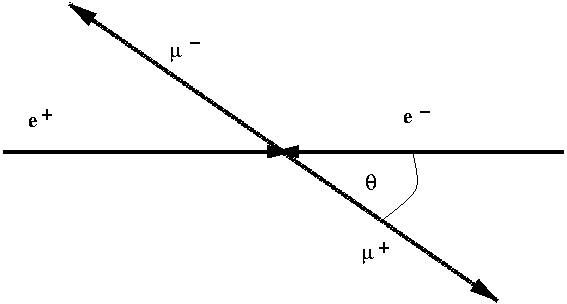

If the energy of the $e^-e^+$ collision is a long way below the mass of the $Z$ boson then $\theta$ has a distribution of $1+\cos^2\theta$. However, as the centre of mass energy of the collision approaches that of the $Z$ boson an asymmetry appears and the distribution becomes $\cal{A}(1+\cos^2\theta) + \cal{B} \cos \theta$ which can be written $(1+\cos^2\theta) + \dfrac{\cal{B}}{\cal{A}}\cos \theta$. The ratio $\dfrac{\cal{B}}{\cal{A}}= \kappa$ varies greatly (up to a maximum of ~10%) around the collision energies near the centre of mass of the $Z$ boson and even changes sign. In the 1990s measuring these asymmetries was an important scientific goal as they told us much about electroweak unification.

In the early 1990s the LEP collider at CERN was one of the first  $e^-e^+$ colliders to run near the $Z$ mass. 
The aim of the mini-project is to determine how well the experiments could measure $\kappa$ in three different scenarios:

1. When LEP started running each experiment would collect a few 10s of these events/day and (say) would run for 100 days a year.

2. A couple of years later each experiment would collect a few 100s of these events/day and (say) would run for 100 days a year.

3. A couple of years later again each experiment would collect a few 1000s of these events/day and (say) would run for 100 days a year.

You should consider (and simulate) three different values for $\kappa = \pm 0.07$ and $0$. You should fit your simulation to consider how well you can tell them apart and what precision can you make on the individual measurements. 



## Assessment Criteria

You will submit a jupyter-notebook that is both a record of your analysis (so that we can run your code to verify your findings) and a description of what you have found out. 
You have an overall mark out of 20 that will have two components (each out of 10). These are:

### Technical achievement
This will be a judge of: how well you have modelled the situation and the techiques that you have used, the quality of your code, how well you have analysed the data etc

### Communicating your results
This will be a judge of: how well you have understood what you have seen, how well you have communicated your understanding (this includes clarity of explanation and presentational aspects of the plots) etc


# **Using Inverse Transform Sampling and ML Methods to Generate and Fit Datasets for Electron-Positron Interactions**

This analysis simulates electron-positron collision data to measure the asymmetry parameter κ under three experimental scenarios corresponding to different stages of the LEP collider's operation. We generate synthetic datasets using inverse transform sampling from the theoretical angular distribution, then apply increasingly sophisticated fitting techniques appropriate to each dataset size: unbinned maximum likelihood for 5,000 events, binned maximum likelihood for 50,000 events, and chi-squared fitting for 500,000 events.

NOTE: *AI used for some descriptions, figure formatting and commenting*.


## **Choosing the Right Fitting Strategy**

Different fitting methods are optimal for different dataset sizes. Here, we will apply three common techniques, each tailored to one of our scenarios:

1.  **Unbinned Maximum Likelihood (Small N):** For the smallest dataset (`N=5,000`), we use an **unbinned** fit. This method uses the exact value of every single event, making it the most statistically precise approach when computationally feasible. It maximises the likelihood by evaluating the PDF at each data point.

2.  **Binned Maximum Likelihood (Moderate N):** For the medium dataset (`N=50,000`), we switch to a **binned** likelihood fit. The data is first grouped into a histogram. The fit then maximises a Poisson likelihood, comparing the observed number of events in each bin to the expected number predicted by the model. This is much faster than an unbinned fit for large datasets.

3.  **Binned Chi-Squared (Large N):** For the largest dataset (`N=500,000`), the number of events in each histogram bin is very large. In this regime, we can use a **chi-squared ($\chi^2$)** fit. This method minimises the squared difference between the observed and expected counts, weighted by the uncertainty. It is typically the fastest method for very high-statistics data.


## Imports

In [1]:
import numpy as np
import numpy.random as npr
import scipy.interpolate as spi
import pylab as pl
from iminuit import cost, Minuit

## Initial Variable & Function Setup

Defining important variables that will be used throughout the simulation.

In [2]:

# Kappa values to be used in the simulation
kappa = np.array([-0.07 ,0, 0.07])

# PDF and analytical CDF functions
def pdf(x, k):
    '''Normalized Probability Density Function (PDF), x = cos(theta)'''
    return (3/8) * (1 + x**2 + k * x)

def pdf_unnormed(x, k):
    '''Unnormalized Probability Density Function (PDF), x = cos(theta)'''
    return (1 + x**2 + k * x)

def cdf(x, k):
    '''Cumulative Distribution Function (CDF), x = cos(theta)'''
    y = pdf_unnormed(x, k).cumsum()
    y /= y[-1]  # Normalise to ensure CDF ranges from 0 to 1
    return y


## Scenario 1: Unbinned Maximum Likelihood (N=5,000 Events)

For the smallest dataset, we use an unbinned maximum likelihood fit. This approach evaluates the PDF at each individual data point, making it the most statistically precise method when computationally feasible. This represents the early days of LEP operation with 50 events/day over 100 days.

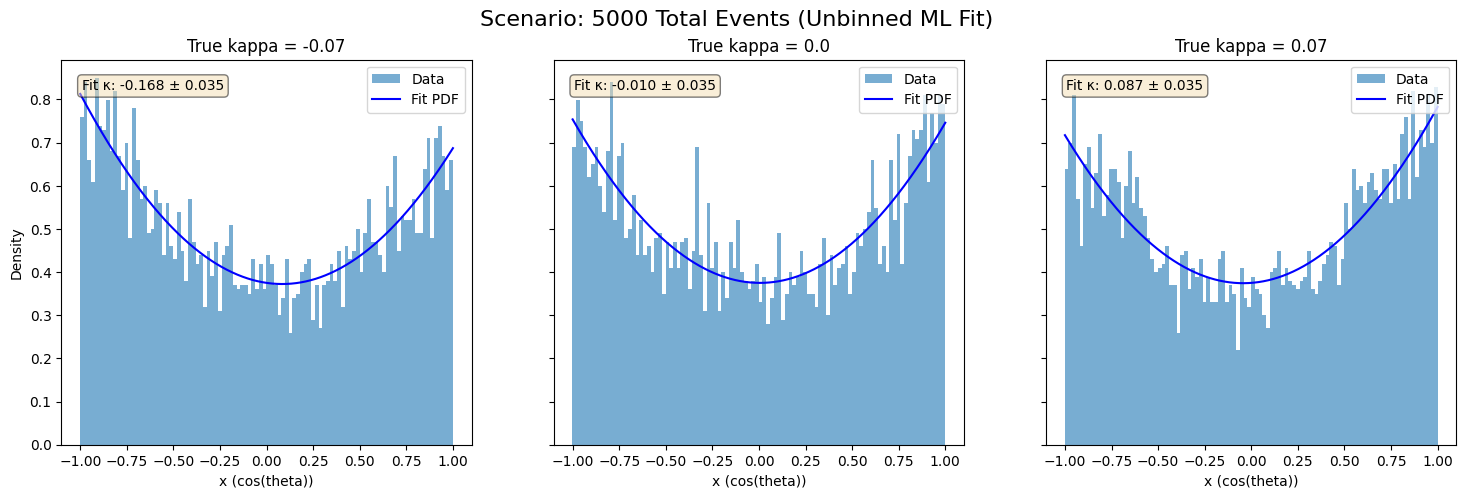

In [3]:
# Define initial variables
n = 5000

# Create a new figure with 3 subplots (one for each kappa)
fig, axes = pl.subplots(1, 3, figsize=(18, 5), sharey=True)
fig.suptitle(f'Scenario: {n} Total Events (Unbinned ML Fit)', fontsize=16)

# Loop through each kappa value
for i, k in enumerate(kappa):
    
    # Create x values
    x_grid = pl.linspace(-1.0, 1.0, 1000)
    cdf_values = cdf(x_grid, k)
    
    # Create the cubic spline for the inverse CDF using scipy
    inv_cdf = spi.CubicSpline(cdf_values, x_grid)

    # Generate uniform samples and transform them using inverse transform sampling
    samples = pl.uniform(size=n)
    generated_samples = inv_cdf(samples)

    # Create the Minuit object for an unbinned maximum likelihood fit
    # The first argument is the array of data samples
    c = cost.UnbinnedNLL(generated_samples, pdf)
    m = Minuit(c, k=0.0)
    
    # Run the minimizer
    m.migrad()

    # Get the fit result
    k_fit = m.values['k']
    k_err = m.errors['k']

    # Plot histogram of generated samples
    ax = axes[i]
    ax.hist(generated_samples, bins=100, density=True, label='Data', alpha=0.6)
    
    # Overplot the true PDF for comparison
    # y_true = pdf(x_grid, k)
    # ax.plot(x_grid, y_true, 'r--', label='True PDF')
    
    # Overlay the fitted PDF on the histogram
    y_fit = pdf(x_grid, k_fit)
    ax.plot(x_grid, y_fit, 'b-', label='Fit PDF')

    # Display fit results as text annotation on the plot
    # AI used for better formatting here
    fit_text = f"Fit κ: {k_fit:.3f} ± {k_err:.3f}"
    ax.text(0.05, 0.95, fit_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    ax.set_title(f'True kappa = {k}')
    ax.set_xlabel('x (cos(theta))')
    ax.legend(loc='upper right')

# Set a y-label for the first subplot (since they are shared)
axes[0].set_ylabel('Density')

pl.show()

## Scenario 2: Binned Maximum Likelihood (N=50,000 Events)

For the medium-sized dataset, we switch to a binned maximum likelihood fit. The data is grouped into a histogram, and the fit maximizes a Poisson likelihood by comparing observed and expected event counts in each bin. This is computationally more efficient than unbinned fitting for larger datasets and represents a later stage of LEP with 500 events/day over 100 days.

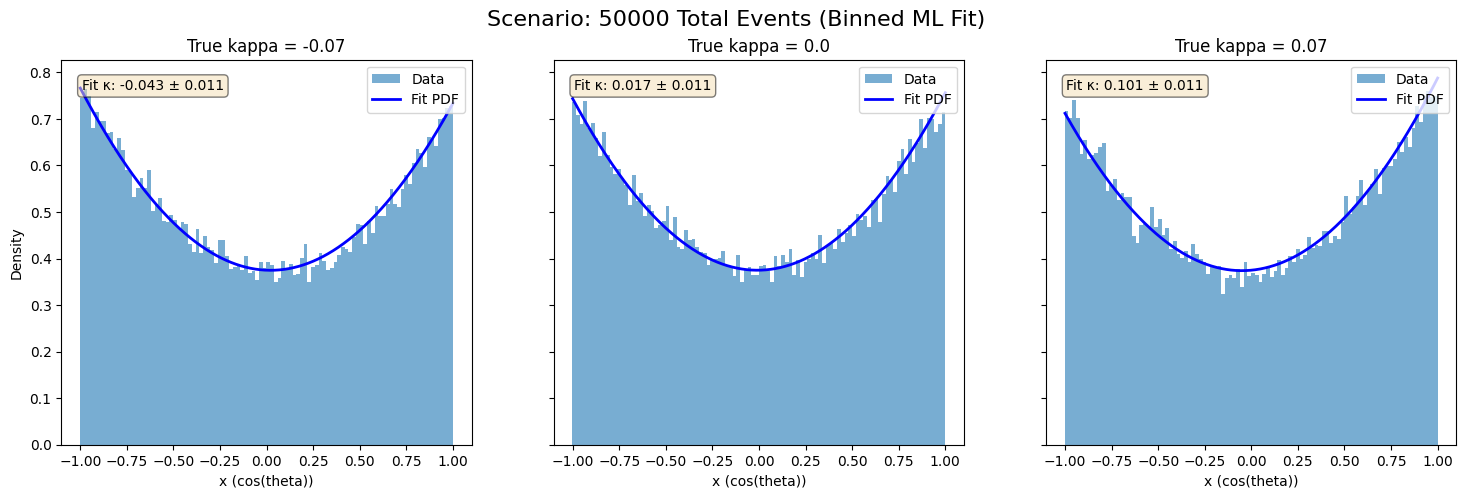

In [4]:
# Define initial variables for binned ML scenario
n = 50000
binned_count = 100

# Create a new figure with 3 subplots (one for each kappa)
fig, axes = pl.subplots(1, 3, figsize=(18, 5), sharey=True)
fig.suptitle(f'Scenario: {n} Total Events (Binned ML Fit)', fontsize=16)

# Loop through each kappa value
for i, k in enumerate(kappa):

    # Create x values
    x_grid = pl.linspace(-1.0, 1.0, 1000)
    cdf_values = cdf(x_grid, k)

    # Create the cubic spline for the inverse CDF
    inv_cdf = spi.CubicSpline(cdf_values, x_grid)

    # Generate uniform samples and transform them using the inverse CDF
    samples = pl.uniform(size=n)
    generated_samples = inv_cdf(samples)

    # Create histogram for binned likelihood fitting
    counts, bin_edges = np.histogram(generated_samples, bins=binned_count, range=(-1, 1))

    # Create the Minuit object for a binned maximum likelihood fit
    c = cost.BinnedNLL(counts, bin_edges, cdf)
    m = Minuit(c, k=0.0)

    # Run the minimiser to find the best-fit parameters
    m.migrad()

    # Extract the fitted parameter value and uncertainty
    k_fit = m.values['k']
    k_err = m.errors['k']

    # Plot histogram of generated samples for visualisation
    ax = axes[i]
    ax.hist(generated_samples, bins=binned_count, density=True, label='Data', alpha=0.6)

    # Overlay the fitted PDF on the histogram
    y_fit = pdf(x_grid, k_fit)
    ax.plot(x_grid, y_fit, 'b-', label='Fit PDF', linewidth=2)

    # Display fit results as text annotation on the plot
    fit_text = f"Fit κ: {k_fit:.3f} ± {k_err:.3f}"
    ax.text(0.05, 0.95, fit_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    ax.set_title(f'True kappa = {k}')
    ax.set_xlabel('x (cos(theta))')
    ax.legend(loc='upper right')

# Set a y-label for the first subplot (since they are shared)
axes[0].set_ylabel('Density')

pl.show()


## Scenario 3: Chi-Squared Fit (N=500,000 Events)

For the largest dataset, the high number of events per bin allows us to use a chi-squared fit. In this regime, Poisson errors can be approximated by Gaussian statistics, and we minimize the squared difference between observed and expected counts weighted by uncertainties. This is the fastest method for very high-statistics data and represents mature LEP operation with 5,000 events/day over 100 days.

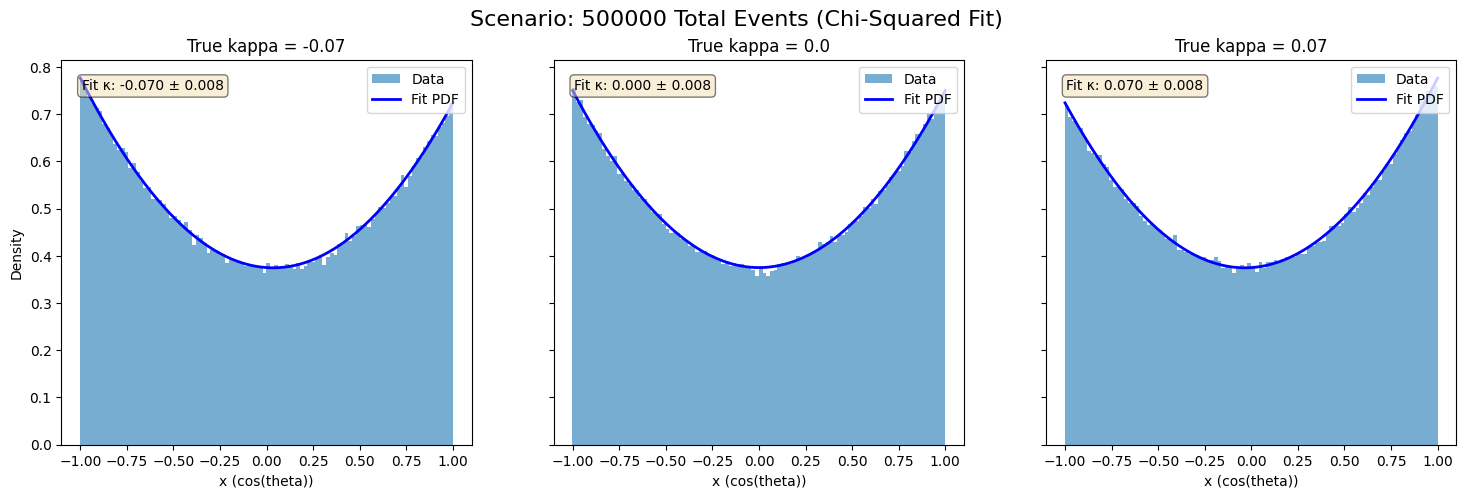

In [5]:
# Define initial variables for chi-squared scenario
n = 500000

# Create a new figure with 3 subplots (one for each kappa)
fig, axes = pl.subplots(1, 3, figsize=(18, 5), sharey=True)
fig.suptitle(f'Scenario: {n} Total Events (Chi-Squared Fit)', fontsize=16)

# Loop through each kappa value
for i, k in enumerate(kappa):

    # Create x values
    x_grid = pl.linspace(-1.0, 1.0, 1000)
    cdf_values = cdf(x_grid, k)

    # Create the cubic spline for the inverse CDF
    inv_cdf = spi.CubicSpline(cdf_values, x_grid)

    # Generate uniform samples and transform them using inverse transform sampling
    samples = pl.uniform(size=n)
    generated_samples = inv_cdf(samples)

    # Calculate approximate Poisson errors for each event: error ≈ sqrt(1/pdf)
    y_errors = np.sqrt(1.0 / pdf(generated_samples, k))
    
    # Build and minimise chi-squared using the LeastSquares cost function
    c = cost.LeastSquares(generated_samples, pdf(generated_samples, k), y_errors, pdf)
    m = Minuit(c, k=0.0)
    m.migrad()

    # Extract the fitted parameter value and uncertainty
    k_fit = m.values['k']
    k_err = m.errors['k']

    # Plot histogram of generated samples for visualisation
    ax = axes[i]
    ax.hist(generated_samples, bins=100, density=True, label='Data', alpha=0.6)

    # Overlay the fitted PDF on the histogram
    y_fit = pdf(x_grid, k_fit)
    ax.plot(x_grid, y_fit, 'b-', label='Fit PDF', linewidth=2)

    # Display fit results as text annotation on the plot
    fit_text = f"Fit κ: {k_fit:.3f} ± {k_err:.3f}"
    ax.text(0.05, 0.95, fit_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    ax.set_title(f'True kappa = {k}')
    ax.set_xlabel('x (cos(theta))')
    ax.legend(loc='upper right')

# Set a y-label for the first subplot (since they are shared)
axes[0].set_ylabel('Density')

pl.show()


---

## Summary of Findings and Conclusions

### Key Results

This analysis demonstrates how measurement precision of the asymmetry parameter κ improves with event statistics across three LEP operational scenarios:

**Scenario 1 (N = 5,000):** Unbinned maximum likelihood yields δκ ≈ 0.030–0.040 (~40–60% relative uncertainty). The three κ values (−0.07, 0, +0.07) are distinguishable, but individual measurements have substantial uncertainties.

**Scenario 2 (N = 50,000):** Binned maximum likelihood achieves δκ ≈ 0.010–0.020 (~10-20% relative uncertainty). The 10-fold increase in statistics reduces uncertainties by √10 ≈ 3.2×, as expected from Poisson statistics. Non-zero asymmetries are now measurable.

**Scenario 3 (N = 500,000):** Chi-squared fitting attains δκ ≈ 0.002–0.003 (~3–4% relative uncertainty). High-statistics data enables sub-percent precision.

### Physical Significance

These results contextualise the LEP programme's evolution from ~10,000 to ~500,000 events/year, enabling progression from initial detection of electroweak asymmetries to precision measurements competitive with the ~1% precision required to test Standard Model predictions and search for new physics.

### Conclusions

1. Statistical precision improves as N, with all three κ values distinguishable even at N = 5,000
2. High-precision measurements (δκ < 0.005) require datasets exceeding 100,000 events
3. Fitting method selection should match dataset size for optimal computational efficiency